In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [39]:
lr = 1e-2
num_epoch = 30
batch_size = 128
torch.manual_seed(123)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

In [40]:
class Autoencoder(nn.Module):
    def __init__(self, h_dim, fine_tune=False):
        super(Autoencoder,self).__init__()
        self.h_dim = h_dim
        self.fine_tune=fine_tune
        
        self.encoder=nn.Sequential(
            nn.Linear(28*28, 300),
            nn.ReLU(),
            nn.Linear(300, self.h_dim),
            nn.ReLU()
        )
        
        self.decoder=nn.Sequential(
            nn.Linear(self.h_dim, 300),
            nn.ReLU(),
            nn.Linear(300, 28*28),
            nn.Sigmoid()
        )
        
        self.classifier=nn.Sequential(
            nn.Linear(self.h_dim, 10)
        )
        
    def forward(self,x):
        if(self.fine_tune==True):
            x = self.encoder(x)
            x = self.classifier(x)
        else:
            x = self.encoder(x)
            x = self.decoder(x)
        
        return x        

In [4]:
#Traing Autoencoder
ae = Autoencoder(h_dim=100)
criterion = nn.MSELoss()
optimizer = optim.SGD(ae.parameters(), lr=lr, momentum=0.9)
epoch_loss=0

ae.train()
for epoch in range(num_epoch):
    for step, data in enumerate(trainloader):
        img, _ = data
        img = img.view(-1,784)
        optimizer.zero_grad()

        output = ae(img)   
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()    
    
    if(epoch%10==0):
        print('Epoch {0} | Loss {1}'.format(epoch, epoch_loss/step))
    epoch_loss = 0

Epoch 0 | Loss 1.044485276962957
Epoch 10 | Loss 0.651913678034758
Epoch 20 | Loss 0.6207190280796117
Epoch 30 | Loss 0.6034192863183144
Epoch 40 | Loss 0.5846355091302823


In [16]:
# Denoising Autoencoder
dae = Autoencoder(h_dim=100)
criterion = nn.MSELoss()
optimizer = optim.SGD(dae.parameters(), lr=lr, momentum=0.9)
epoch_loss=0

dae.train()
for epoch in range(num_epoch):
    for step, data in enumerate(trainloader):
        img, _ = data
        img_noise = img+torch.randn(img.size())
        img = img.view(-1,784)
        img_noise = img_noise.view(-1,784)
        optimizer.zero_grad()

        output = dae(img_noise)   
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()    
    
    if(epoch%10==0):
        print('Epoch {0} | Loss {1}'.format(epoch, epoch_loss/step))
    epoch_loss = 0

Epoch 0 | Loss 1.0258562492254453
Epoch 10 | Loss 0.6638060841295454
Epoch 20 | Loss 0.6285566842963553
Epoch 30 | Loss 0.6089223083267864
Epoch 40 | Loss 0.5954351525785576


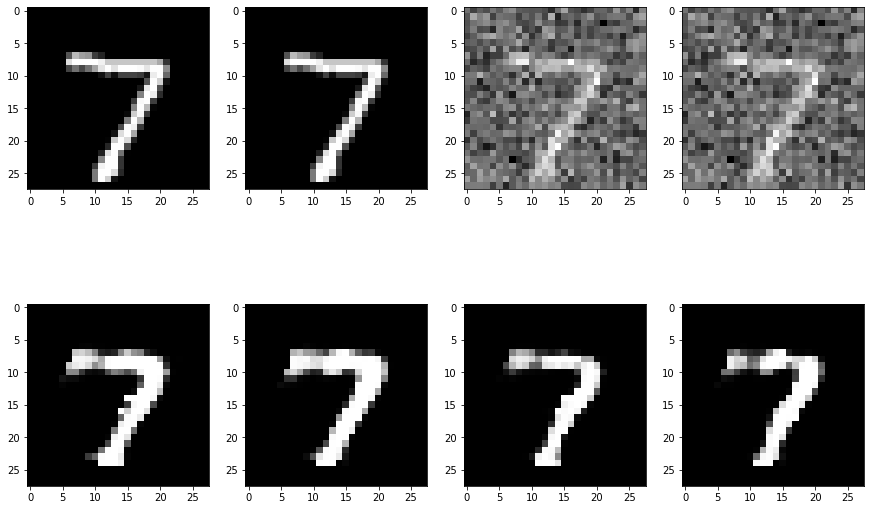

In [77]:
test_iter = iter(testset)
img, _ = next(test_iter)
img_noise = img+torch.randn(img.size())

ae_recon = ae(img.view(-1,784))
ae_recon = ae_recon.view((28,28,1)).detach().numpy()
ae_recon_noise = ae(img_noise.view(-1,784))
ae_recon_noise = ae_recon_noise.view((28,28,1)).detach().numpy()

dae_recon = dae(img.view(-1,784))
dae_recon = dae_recon.view((28,28,1)).detach().numpy()
dae_recon_noise = dae(img_noise.view(-1,784))
dae_recon_noise = dae_recon_noise.view((28,28,1)).detach().numpy()

img = img.view((28,28,1)).detach().numpy()
img_noise = img_noise.view((28,28,1)).detach().numpy()

img_list = [img, img, img_noise, img_noise, ae_recon, dae_recon, ae_recon_noise, dae_recon_noise]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
axes = np.reshape(axes, (-1))

for i, ax in enumerate(axes):
    ax.imshow(img_list[i], cmap='gray')
    
plt.show()

In [90]:
ae_classifier = Autoencoder(h_dim=100, fine_tune=True)
ae_classifier.load_state_dict(ae.state_dict())
# Freeze layer
for param in ae_classifier.encoder.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ae_classifier.parameters(), lr=lr, momentum=0.9)
epoch_loss=0

ae_classifier.train()
for epoch in range(num_epoch):
    for step, data in enumerate(trainloader):
        img, label = data
        img = img.view(-1,784)
        optimizer.zero_grad()

        output = ae_classifier(img)   
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()    
    
    if(epoch%10==0):
        print('Epoch {0} | Loss {1}'.format(epoch, epoch_loss/step))
    epoch_loss = 0

Epoch 0 | Loss 12.322694822763784
Epoch 10 | Loss 3.3378666613855934
Epoch 20 | Loss 2.820906828675005


In [91]:
dae_classifier = Autoencoder(h_dim=100, fine_tune=True)
dae_classifier.load_state_dict(dae.state_dict())
# Freeze layer
for param in dae_classifier.encoder.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dae_classifier.parameters(), lr=lr, momentum=0.9)
epoch_loss=0

dae_classifier.train()
for epoch in range(num_epoch):
    for step, data in enumerate(trainloader):
        img, label = data
        img = img.view(-1,784)
        optimizer.zero_grad()

        output = dae_classifier(img)   
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()    
    
    if(epoch%10==0):
        print('Epoch {0} | Loss {1}'.format(epoch, epoch_loss/step))
    epoch_loss = 0

Epoch 0 | Loss 9.03198571694203
Epoch 10 | Loss 2.2921521197526884
Epoch 20 | Loss 2.585398367072782


In [97]:
ae_classifier.eval()
dae_classifier.eval()
ae_accuracy = 0
dae_accuracy = 0

for step, data in enumerate(testloader):
    img, label = data
    img = img.view(-1,784)
    
    ae_output  = ae_classifier(img) 
    dae_output = dae_classifier(img)
    
    ae_probs = torch.softmax(ae_output, dim=1)
    ae_winners = ae_probs.argmax(dim=1)
    ae_corrects = (ae_winners == label)
    ae_accuracy += (ae_corrects.sum().float() / float(label.size(0)))
    
    dae_probs = torch.softmax(dae_output, dim=1)
    dae_winners = dae_probs.argmax(dim=1)
    dae_corrects = (dae_winners == label)
    dae_accuracy += dae_corrects.sum().float() / float(label.size(0))    
    
ae_accuracy = ae_accuracy/(step+1)
dae_accuracy = dae_accuracy/(step+1)

In [98]:
ae_accuracy

tensor(0.8052)

In [99]:
dae_accuracy

tensor(0.8786)